# 机器学习方法
## 特征一：文本相似度计算

In [150]:
import pandas as pd
import numpy as np
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import jieba
import jieba.analyse
import matplotlib.pyplot as plt

### 读取提前下载好的Glove词向量，这里采用的是glove.6B.50d，每一个单词用50维的词向量表示

In [47]:
#读取glove词向量并存储在字典中
word_vector={}
with open('glove.txt','r',encoding='utf—8') as glove: 
    for line in glove.readlines():
        line = list(line.split())
        word_vector[line[0]]=np.array(line[1:],dtype=float).reshape(1,50)

In [165]:
print("king的词向量：")
king_vector=word_vector['king']
print(type(king_vector))
print(king_vector)

king的词向量：
<class 'numpy.ndarray'>
[[ 0.50451   0.68607  -0.59517  -0.022801  0.60046  -0.13498  -0.08813
   0.47377  -0.61798  -0.31012  -0.076666  1.493    -0.034189 -0.98173
   0.68229   0.81722  -0.51874  -0.31503  -0.55809   0.66421   0.1961
  -0.13495  -0.11476  -0.30344   0.41177  -2.223    -1.0756   -1.0783
  -0.34354   0.33505   1.9927   -0.04234  -0.64319   0.71125   0.49159
   0.16754   0.34344  -0.25663  -0.8523    0.1661    0.40102   1.1685
  -1.0137   -0.21585  -0.15155   0.78321  -0.91241  -1.6106   -0.64426
  -0.51042 ]]


### 读取数据并加载停用词表

In [6]:
stop_words = set(stopwords.words('english'))
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

In [151]:
print("数据集信息：")
train_data.info()
print("————————————————")
print("数据内容概览：")
train_data.head()
print('得到样本：{}个'.format(train_data.shape[0]))
print('得到测试样例：{}个'.format(test_data.shape[0]))

数据集信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
label       8000 non-null int64
question    8000 non-null object
sentence    8000 non-null object
dtypes: int64(1), object(2)
memory usage: 187.6+ KB
————————————————
数据内容概览：
得到样本：8000个
得到测试样例：1600个


### 定义对句子进行清洗的函数，过滤掉停用词和标点符号

In [22]:
#传入的参数sentence是句子经过tokenize后的token组成的列表
def clean_sentence(sentence):
    sentence = filter(lambda x: len(x) > 1, sentence)
    word_list=[]
    for word in sentence:
        word=word.lower()
        if word not in stop_words:    #过滤没有意义停用词
                if word != '\t':
                    word_list.append(word)
    result=" ".join(word_list)
    return result

### 利用nltk中的word_tokenize模块对question和sentence进行分词，利用jieba中的extract_tags模块提取关键词
### question句子较短，提取3个关键词，sentence则提取10个关键词，这里的关键词个数都可以当成模型的超参数

In [153]:
#处理训练集
train_question_key_word_list=[]
train_sentence_key_word_list=[]

train_question_len_list=[]
train_sentence_len_list=[]

KEY_WORD_NUM_QUESTION=3
KEY_WORD_NUM_SENTENCE=10
for i,row in train_data.iterrows():
    question_tokenized=word_tokenize(row['question'])
    sentence_tokenized=word_tokenize(row['sentence'])
    
    train_question_len_list.append(len(question_tokenized))
    train_sentence_len_list.append(len(sentence_tokenized))
    
    question_cleaned=clean_sentence(question_tokenized)
    sentence_cleaned=clean_sentence(sentence_tokenized)

    
    question_key_word=jieba.analyse.extract_tags(question_cleaned,topK=KEY_WORD_NUM_QUESTION)
    sentence_key_word=jieba.analyse.extract_tags(sentence_cleaned,topK=KEY_WORD_NUM_SENTENCE)
    
    train_question_key_word_list.append(question_key_word)
    train_sentence_key_word_list.append(sentence_key_word)

In [154]:
#处理测试集
test_question_key_word_list=[]
test_sentence_key_word_list=[]

for i,row in test_data.iterrows():
    question_tokenized=word_tokenize(row['question'])
    sentence_tokenized=word_tokenize(row['sentence'])
    
    question_cleaned=clean_sentence(question_tokenized)
    sentence_cleaned=clean_sentence(sentence_tokenized)

    
    question_key_word=jieba.analyse.extract_tags(question_cleaned,topK=KEY_WORD_NUM_QUESTION)
    sentence_key_word=jieba.analyse.extract_tags(sentence_cleaned,topK=KEY_WORD_NUM_SENTENCE)
    
    test_question_key_word_list.append(question_key_word)
    test_sentence_key_word_list.append(sentence_key_word)

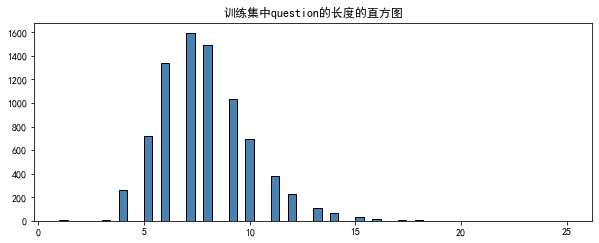

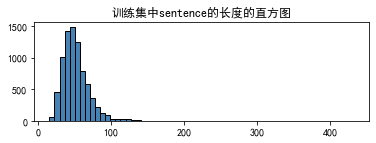

In [156]:
#针对训练集中tokenize后的question和sentence长度绘制直方图
plt.rcParams['font.sans-serif']=['SimHei']  #解决matplotlib无法显示中文字符的问题，设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False
figure = plt.figure('直方图均衡化',figsize=(10,8))         
plt.subplot(2,1,1) 
plt.hist(x = train_question_len_list, # 指定绘图数据
          bins = 60, # 指定直方图中条块的个数
          color = 'steelblue', # 指定直方图的填充色
          edgecolor = 'black' # 指定直方图的边框色
          )
plt.title('训练集中question的长度的直方图')
plt.show()
plt.subplot(2,1,2) 
plt.hist(x = train_sentence_len_list, # 指定绘图数据
          bins = 60, # 指定直方图中条块的个数
          color = 'steelblue', # 指定直方图的填充色
          edgecolor = 'black' # 指定直方图的边框色
          )
plt.title('训练集中sentence的长度的直方图')
plt.show()

### 定义余弦相似度计算函数，也可以利用from sklearn.metrics.pairwise import cosine_similarity

In [65]:
def similarityCalu(vector1,vector2):
    vector1Mod=np.sqrt(vector1.dot(vector1.T))
    vector2Mod=np.sqrt(vector2.dot(vector2.T))
    if(vector1Mod!=0 and vector2Mod!=0):
        similarity=(vector1.dot(vector2.T))/(vector1Mod*vector2Mod)
    else:
        similarity=0
    return similarity
            

In [166]:
queen_vector=word_vector['queen']
print("king和queen的相似度：")
print(similarityCalu(king_vector,queen_vector))

king和queen的相似度：
[[0.7839043]]


### 根据glove词向量，查找question和sentence中的关键词对应的词向量，求他们的平均值作为question和sentence的文本向量，并且计算相似度。运行时间可能较长。

In [67]:
#对训练集中的question和sentence转换为文本向量，并计算相似度。

train_similarity_list=[]
test_similarity_list=[]

len_of_train_set=len(train_question_key_word_list)  #8000
len_of_test_set=len(test_question_key_word_list)  #1600

for i in range(len_of_train_set):
    question_key_word_list=train_question_key_word_list[i]
    sentence_key_word_list=train_sentence_key_word_list[i]
    
    question_vector=np.zeros(50).reshape(1,50)
    sentence_vector=np.zeros(50).reshape(1,50)
    for key_word in question_key_word_list:
        if(key_word in list(word_vector.keys())):
            question_vector+=np.array(word_vector[key_word])
    
    for key_word in sentence_key_word_list:
        if(key_word in list(word_vector.keys())):
            sentence_vector+=np.array(word_vector[key_word])
    
    question_vector=question_vector/len(question_key_word_list)
    sentence_vector=sentence_vector/len(sentence_key_word_list)
    similarity=similarityCalu(question_vector,sentence_vector)
    train_similarity_list.append(similarity)



E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


#### 输出训练集里若干question和sentence的label和similarity，可以看出，其中大部分label为1的样本中的question和sentence的相似度较高，但是有些样本也存在较大的误差，原因可能有关键词提取算法的准确率不高，利用word2vec去表示文本向量丢失了语序的信息等。

In [75]:
train_labels=list(train_data.label)
for i in range(25):
    print("{}:{}".format(train_labels[i],train_similarity_list[i]))


0:[[0.77511843]]
0:[[0.83539078]]
0:[[0.77212875]]
0:[[0.91001392]]
1:[[0.72087496]]
0:[[0.73439743]]
1:[[0.92719373]]
0:[[0.64957573]]
1:[[0.88121706]]
0:[[0.58780804]]
1:[[0.73834107]]
0:[[0.40204393]]
0:[[0.79069444]]
0:[[0.84316721]]
1:[[0.75537416]]
1:[[0.71607998]]
0:[[0.62487291]]
1:[[0.87506876]]
1:[[0.8918911]]
1:[[0.41706096]]
0:[[0.7203359]]
0:[[0.61063698]]
0:[[0.86838121]]
0:[[0.05222769]]
1:[[0.65596135]]


In [76]:
#对测试集中的question和sentence转换为文本向量，并计算相似度。
for i in range(len_of_test_set):
    question_key_word_list=test_question_key_word_list[i]
    sentence_key_word_list=test_sentence_key_word_list[i]
    
    question_vector=np.zeros(50).reshape(1,50)
    sentence_vector=np.zeros(50).reshape(1,50)
    for key_word in question_key_word_list:
        if(key_word in list(word_vector.keys())):
            question_vector+=np.array(word_vector[key_word])
    
    for key_word in sentence_key_word_list:
        if(key_word in list(word_vector.keys())):
            sentence_vector+=np.array(word_vector[key_word])
    
    question_vector=question_vector/len(question_key_word_list)
    sentence_vector=sentence_vector/len(sentence_key_word_list)
    similarity=similarityCalu(question_vector,sentence_vector)
    test_similarity_list.append(similarity)

In [77]:
test_labels=list(test_data.label)
for i in range(25):
    print("{}:{}".format(test_labels[i],test_similarity_list[i]))


1:[[0.0793699]]
0:[[0.34891954]]
0:[[0.57031847]]
0:[[0.43868344]]
1:[[0.67879063]]
1:[[0.85360266]]
1:[[0.76467934]]
0:[[0.80065088]]
1:[[0.87095117]]
1:[[0.79076574]]
1:[[0.70992501]]
0:[[0.67988949]]
0:[[0.64975593]]
1:[[0.63625762]]
0:[[0.56280119]]
1:[[0.83488512]]
1:[[0.55215127]]
1:[[0.86149988]]
1:[[0.41972144]]
0:[[0.72085461]]
0:[[0.54171223]]
1:[[0.84272321]]
0:[[0.70869726]]
0:[[0.63224769]]
0:[[0.77512496]]


### 利用相似度作为判断依据，根据传统机器学习算法训练模型对测试集进行预测

In [124]:
from sklearn.tree import DecisionTreeClassifier  #决策树
from sklearn.linear_model import LogisticRegression #logistic回归
from sklearn.svm import SVC, LinearSVC   #SVC
from sklearn.ensemble import RandomForestClassifier  #随机森林
from sklearn.naive_bayes import GaussianNB   #朴素贝叶斯

### 准备数据，去除数据中的nan

In [136]:
X=pd.DataFrame({'similarity':train_similarity_list})
y_label=np.array(train_labels)
X_test=pd.DataFrame({'similarity':test_similarity_list})

In [137]:
for i,row in X.iterrows():
        if(np.isnan(row['similarity'])):
            row['similarity']=0
X.to_csv('C:/Users/xx/Desktop/train_set_similarity.csv', index=True)

In [138]:
for i,row in X_test.iterrows():
        if(np.isnan(row['similarity'])):
            row['similarity']=0
X_test.to_csv('C:/Users/xx/Desktop/test_set_similarity.csv', index=True)

### logistic回归

In [139]:
LR = LogisticRegression()
##训练
LR.fit(X,y_label)
##预测
LR_prediction = LR.predict(X_test)
output1 = pd.DataFrame({'label': LR_prediction})
output1.to_csv('C:/Users/xx/Desktop/LR_submission.csv', index=True)

E:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [140]:
pred=np.array(output1.label)
ground_truth=np.array(test_labels)
res = (ground_truth == pred)
acc = res.sum()/len(res)
print("logistic regression准确率：{}".format(acc))

logistic regression准确率：0.55875


### 决策树

In [141]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X, y_label)
DT_prediction = decision_tree.predict(X_test)
output2 = pd.DataFrame({ 'label': DT_prediction})
output2.to_csv('C:/Users/xx/Desktop/DT_submission.csv', index=True)

In [142]:
pred=np.array(output2.label)
ground_truth=np.array(test_labels)
res = (ground_truth == pred)
acc = res.sum()/len(res)
print("决策树准确率：{}".format(acc))

决策树准确率：0.518125


### SVC

In [143]:
svc = SVC()
svc.fit(X, y_label)
SVC_prediction = svc.predict(X_test)
output3 = pd.DataFrame({'label':SVC_prediction})
output3.to_csv('C:/Users/xx/Desktop/SVC_submission.csv', index=True)

E:\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [144]:
pred=np.array(output3.label)
ground_truth=np.array(test_labels)
res = (ground_truth == pred)
acc = res.sum()/len(res)
print("SVC准确率：{}".format(acc))

SVC准确率：0.569375


### RFC

In [145]:
RFCmodel = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=1)
RFCmodel.fit(X, y_label)
predictions = RFCmodel.predict(X_test)

output4 = pd.DataFrame({'label': predictions})
output4.to_csv('C:/Users/xx/Desktop/RFC_submission.csv', index=True)

In [146]:
pred=np.array(output4.label)
ground_truth=np.array(test_labels)
res = (ground_truth == pred)
acc = res.sum()/len(res)
print("RFC准确率：{}".format(acc))

RFC准确率：0.565


### 朴素贝叶斯

In [147]:
clf = GaussianNB()
clf.fit(X, y_label)
predictions = clf.predict(X_test)
output5 = pd.DataFrame({'label': predictions})
output5.to_csv('C:/Users/xx/Desktop/Naive_bayes_submission.csv', index=True)

In [148]:
pred=np.array(output5.label)
ground_truth=np.array(test_labels)
res = (ground_truth == pred)
acc = res.sum()/len(res)
print("朴素贝叶斯准确率：{}".format(acc))

朴素贝叶斯准确率：0.55875
